In [1526]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

import seaborn as sns
import pylab as rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib 
import pandas as pd 
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout,Flatten, Reshape
from sklearn.preprocessing import MinMaxScaler
from  sklearn.model_selection import TimeSeriesSplit, StratifiedKFold
from keras.callbacks import EarlyStopping
from tcn import TCN
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report


In [1527]:
#Read initial data
file_path='seattle-weather.csv'
df = pd.read_csv("seattle-weather.csv",parse_dates=True)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
print(df.head())
df_temp = df["temp_max"]

            precipitation  temp_max  temp_min  wind  weather
date                                                        
2012-01-01            0.0      12.8       5.0   4.7  drizzle
2012-01-02           10.9      10.6       2.8   4.5     rain
2012-01-03            0.8      11.7       7.2   2.3     rain
2012-01-04           20.3      12.2       5.6   4.7     rain
2012-01-05            1.3       8.9       2.8   6.1     rain


## Exploracion de datos

<Axes: xlabel='date', ylabel='temp_max'>

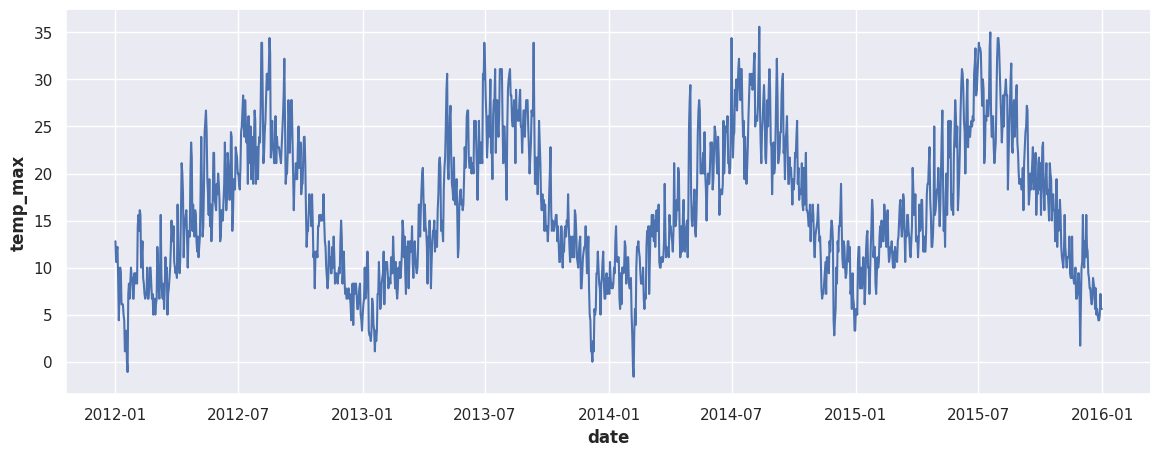

In [1528]:
plt.figure(figsize=(14,5))
sns.lineplot(df_temp)

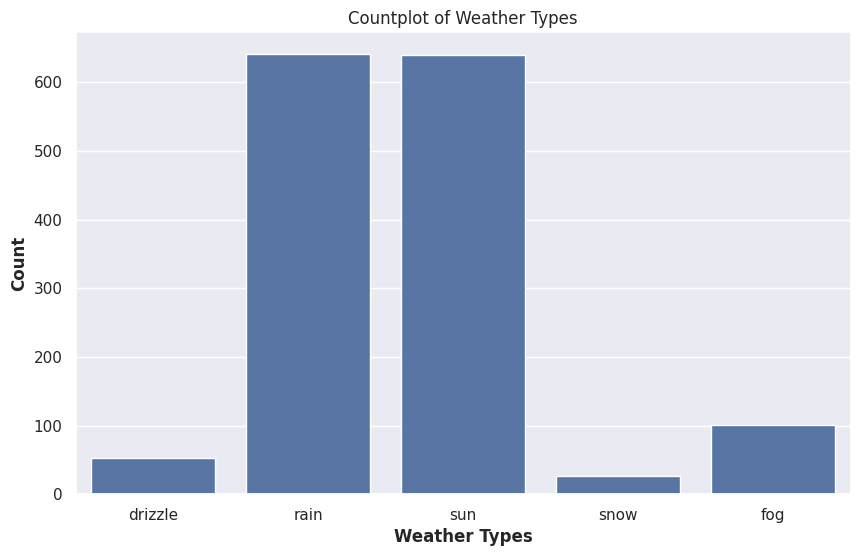

In [1529]:
# Create a countplot for the 'weather' column
plt.figure(figsize=(10, 6))
sns.countplot(x='weather', data=df)
plt.title('Countplot of Weather Types')
plt.xlabel('Weather Types')
plt.ylabel('Count')
plt.show()

<Axes: xlabel='wind', ylabel='Count'>

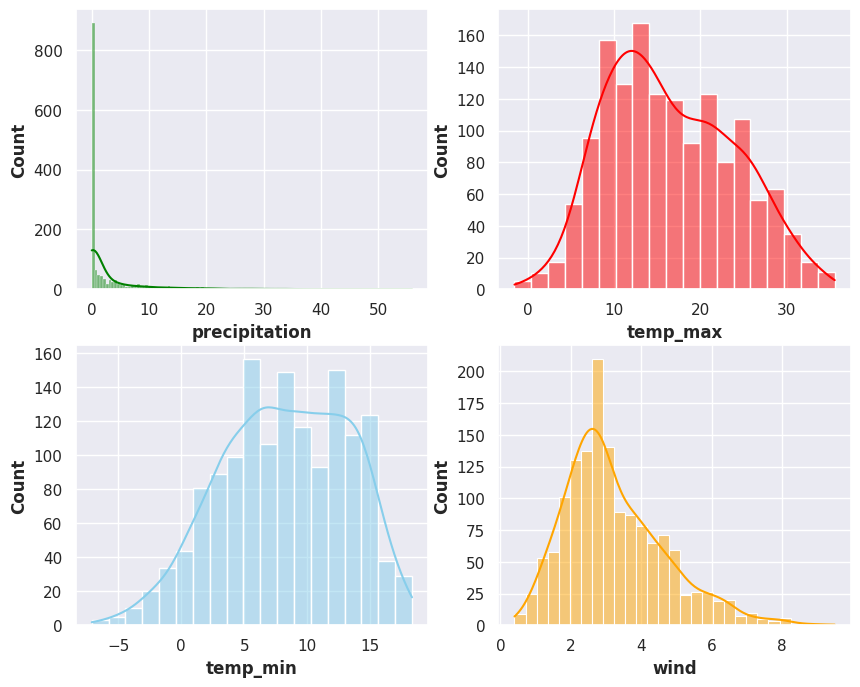

In [1530]:
sns.set(style="darkgrid")
fig,axs=plt.subplots(2,2,figsize=(10,8))
sns.histplot(data=df,x="precipitation",kde=True,ax=axs[0,0],color='green')
sns.histplot(data=df,x="temp_max",kde=True,ax=axs[0,1],color='red')
sns.histplot(data=df,x="temp_min",kde=True,ax=axs[1,0],color='skyblue')
sns.histplot(data=df,x="wind",kde=True,ax=axs[1,1],color='orange')

In [1531]:
df[["precipitation","temp_max","temp_min","wind"]].describe()

,precipitation,temp_max,temp_min,wind
count,1461.000000,1461.000000,1461.000000,1461.000000
mean,3.029432,16.439083,8.234771,3.241136
std,6.680194,7.349758,5.023004,1.437825
min,0.000000,-1.600000,-7.100000,0.400000
25%,0.000000,10.600000,4.400000,2.200000
50%,0.000000,15.600000,8.300000,3.000000
75%,2.800000,22.200000,12.200000,4.000000
max,55.900000,35.600000,18.300000,9.500000


In [1532]:
numeric_cols = df.select_dtypes(include=np.number).columns
Q1 = df[numeric_cols].quantile(0.25)
Q3 = df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1
df = df[~((df[numeric_cols] < (Q1 - 1.5 * IQR)) | (df[numeric_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]


In [1533]:
df.head()

,precipitation,temp_max,temp_min,wind,weather
date,,,,,
2012-01-01,0.0,12.8,5.0,4.7,drizzle
2012-01-03,0.8,11.7,7.2,2.3,rain
2012-01-05,1.3,8.9,2.8,6.1,rain
2012-01-06,2.5,4.4,2.2,2.2,rain
2012-01-07,0.0,7.2,2.8,2.3,rain


In [1534]:
# one hot encoding of weather column
df = pd.get_dummies(df, columns=['weather'])
df.head()

,precipitation,temp_max,temp_min,wind,weather_drizzle,weather_fog,weather_rain,weather_snow,weather_sun
date,,,,,,,,,
2012-01-01,0.0,12.8,5.0,4.7,True,False,False,False,False
2012-01-03,0.8,11.7,7.2,2.3,False,False,True,False,False
2012-01-05,1.3,8.9,2.8,6.1,False,False,True,False,False
2012-01-06,2.5,4.4,2.2,2.2,False,False,True,False,False
2012-01-07,0.0,7.2,2.8,2.3,False,False,True,False,False


In [1535]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)



In [1536]:
scaled_data.shape

(1233, 9)

In [1537]:
print(scaled_data[0])

[0.         0.38709677 0.47637795 0.69354839 1.         0.
 0.         0.         0.        ]


In [1538]:
cols=df.columns

In [1539]:
X=scaled_data[:,:4]
y=scaled_data[:,4:]

In [1540]:
#shape of X_s and y_s
X, y = np.array(X), np.array(y)
print(X.shape)
print(y.shape)

(1233, 4)
(1233, 5)


In [1541]:
print(X[0])

[0.         0.38709677 0.47637795 0.69354839]


In [1542]:
print(y[0])

[1. 0. 0. 0. 0.]


In [1543]:
print(X[1])

[0.11594203 0.35752688 0.56299213 0.30645161]


In [1544]:
def build_model(input_shape, output_shape=5):
    model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(input_shape,1)),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(output_shape, activation='softmax')  # 5 output units for 5 classes and softmax activation for multi-class classification
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

early_stop=EarlyStopping(monitor='val_loss',patience=10)

(998, 4)
Epoch 1/1000
32/32 [==============================] - 1s 8ms/step - loss: 1.3382 - accuracy: 0.5691 - val_loss: 1.2786 - val_accuracy: 0.4234
Epoch 2/1000
32/32 [==============================] - 0s 6ms/step - loss: 1.0668 - accuracy: 0.5261 - val_loss: 1.2578 - val_accuracy: 0.4234
Epoch 3/1000
32/32 [==============================] - 0s 6ms/step - loss: 1.0107 - accuracy: 0.6062 - val_loss: 1.2107 - val_accuracy: 0.4865
Epoch 4/1000
32/32 [==============================] - 0s 5ms/step - loss: 0.9784 - accuracy: 0.6453 - val_loss: 1.1620 - val_accuracy: 0.5856
Epoch 5/1000
32/32 [==============================] - 0s 6ms/step - loss: 0.9415 - accuracy: 0.7004 - val_loss: 1.1202 - val_accuracy: 0.6216
Epoch 6/1000
32/32 [==============================] - 0s 6ms/step - loss: 0.9042 - accuracy: 0.7174 - val_loss: 1.0798 - val_accuracy: 0.6486
Epoch 7/1000
32/32 [==============================] - 0s 6ms/step - loss: 0.8690 - accuracy: 0.7244 - val_loss: 1.0426 - val_accuracy: 0.65

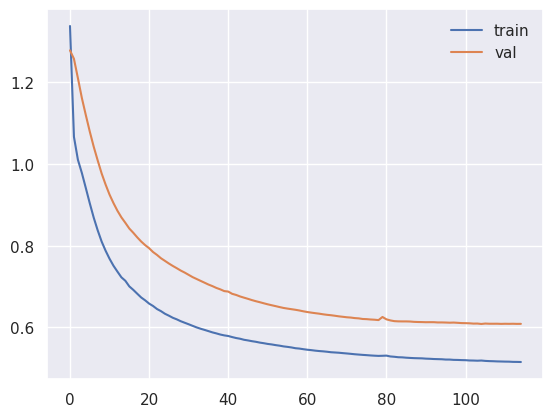

4/4 [==============================] - 0s 4ms/step
Accuracy on the test set: 0.7983870967741935


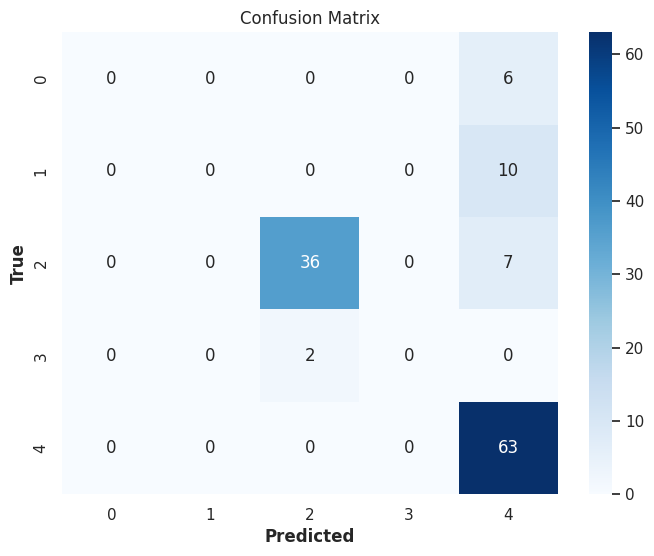

(998, 4)
Epoch 1/1000
32/32 [==============================] - 1s 11ms/step - loss: 1.4473 - accuracy: 0.5120 - val_loss: 1.3338 - val_accuracy: 0.4414
Epoch 2/1000
32/32 [==============================] - 0s 9ms/step - loss: 1.1148 - accuracy: 0.5240 - val_loss: 1.2467 - val_accuracy: 0.4414
Epoch 3/1000
32/32 [==============================] - 0s 5ms/step - loss: 1.0128 - accuracy: 0.5681 - val_loss: 1.2258 - val_accuracy: 0.4414
Epoch 4/1000
32/32 [==============================] - 0s 5ms/step - loss: 0.9714 - accuracy: 0.6643 - val_loss: 1.1661 - val_accuracy: 0.5676
Epoch 5/1000
32/32 [==============================] - 0s 6ms/step - loss: 0.9272 - accuracy: 0.7044 - val_loss: 1.1158 - val_accuracy: 0.6126
Epoch 6/1000
32/32 [==============================] - 0s 5ms/step - loss: 0.8837 - accuracy: 0.7315 - val_loss: 1.0721 - val_accuracy: 0.6396
Epoch 7/1000
32/32 [==============================] - 0s 5ms/step - loss: 0.8462 - accuracy: 0.7425 - val_loss: 1.0330 - val_accuracy: 0.6

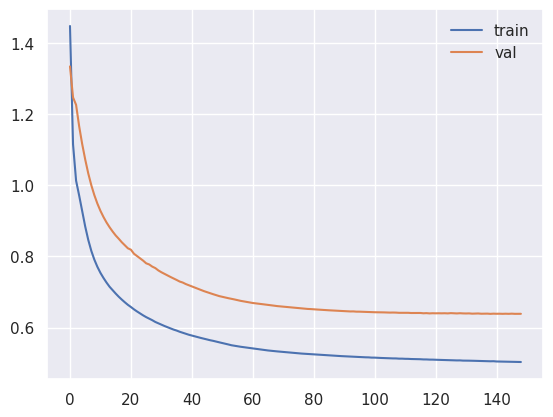

4/4 [==============================] - 0s 2ms/step
Accuracy on the test set: 0.782258064516129


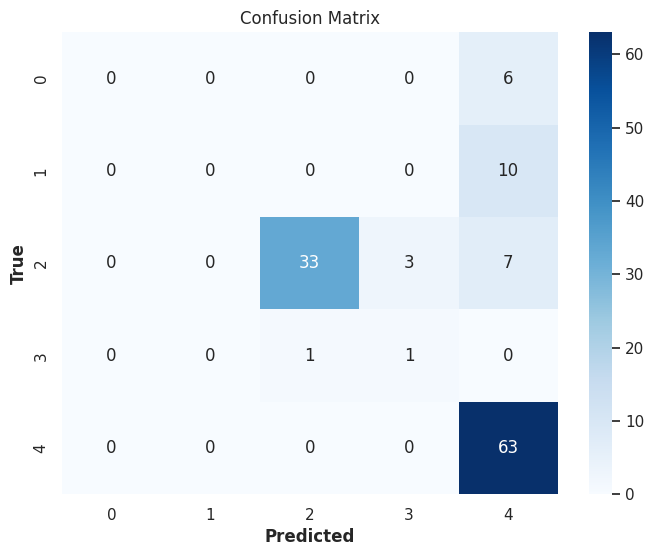

(998, 4)
Epoch 1/1000
32/32 [==============================] - 1s 7ms/step - loss: 1.4303 - accuracy: 0.5882 - val_loss: 1.3314 - val_accuracy: 0.4685
Epoch 2/1000
32/32 [==============================] - 0s 7ms/step - loss: 1.1519 - accuracy: 0.5251 - val_loss: 1.2330 - val_accuracy: 0.4505
Epoch 3/1000
32/32 [==============================] - 0s 7ms/step - loss: 1.0638 - accuracy: 0.5271 - val_loss: 1.2078 - val_accuracy: 0.4505
Epoch 4/1000
32/32 [==============================] - 0s 5ms/step - loss: 1.0353 - accuracy: 0.5691 - val_loss: 1.1586 - val_accuracy: 0.4685
Epoch 5/1000
32/32 [==============================] - 0s 4ms/step - loss: 1.0049 - accuracy: 0.6142 - val_loss: 1.1159 - val_accuracy: 0.5315
Epoch 6/1000
32/32 [==============================] - 0s 5ms/step - loss: 0.9710 - accuracy: 0.6533 - val_loss: 1.0761 - val_accuracy: 0.5766
Epoch 7/1000
32/32 [==============================] - 0s 5ms/step - loss: 0.9368 - accuracy: 0.6743 - val_loss: 1.0347 - val_accuracy: 0.63

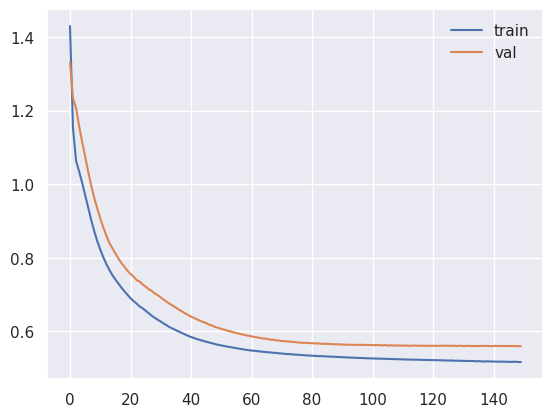

4/4 [==============================] - 0s 2ms/step
Accuracy on the test set: 0.7983870967741935


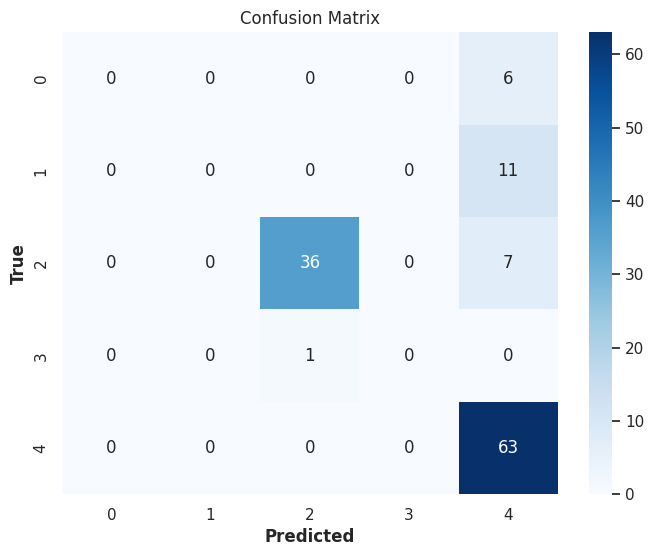

(999, 4)
Epoch 1/1000
32/32 [==============================] - 1s 8ms/step - loss: 1.4681 - accuracy: 0.4364 - val_loss: 1.3670 - val_accuracy: 0.4955
Epoch 2/1000
32/32 [==============================] - 0s 6ms/step - loss: 1.1641 - accuracy: 0.5265 - val_loss: 1.2456 - val_accuracy: 0.4324
Epoch 3/1000
32/32 [==============================] - 0s 6ms/step - loss: 1.0443 - accuracy: 0.5285 - val_loss: 1.2240 - val_accuracy: 0.4324
Epoch 4/1000
32/32 [==============================] - 0s 5ms/step - loss: 1.0082 - accuracy: 0.6176 - val_loss: 1.1763 - val_accuracy: 0.4865
Epoch 5/1000
32/32 [==============================] - 0s 5ms/step - loss: 0.9687 - accuracy: 0.6787 - val_loss: 1.1229 - val_accuracy: 0.5946
Epoch 6/1000
32/32 [==============================] - 0s 5ms/step - loss: 0.9245 - accuracy: 0.7187 - val_loss: 1.0725 - val_accuracy: 0.6577
Epoch 7/1000
32/32 [==============================] - 0s 6ms/step - loss: 0.8832 - accuracy: 0.7337 - val_loss: 1.0225 - val_accuracy: 0.67

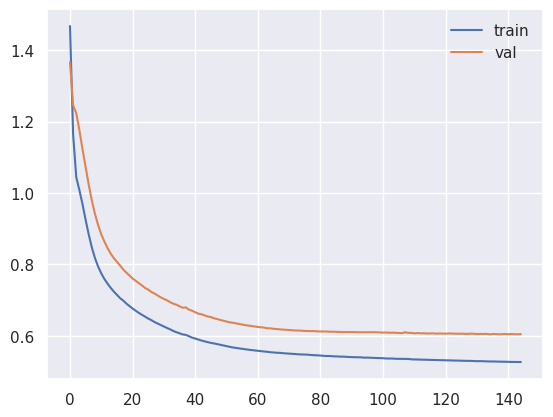

4/4 [==============================] - 0s 2ms/step
Accuracy on the test set: 0.8617886178861789


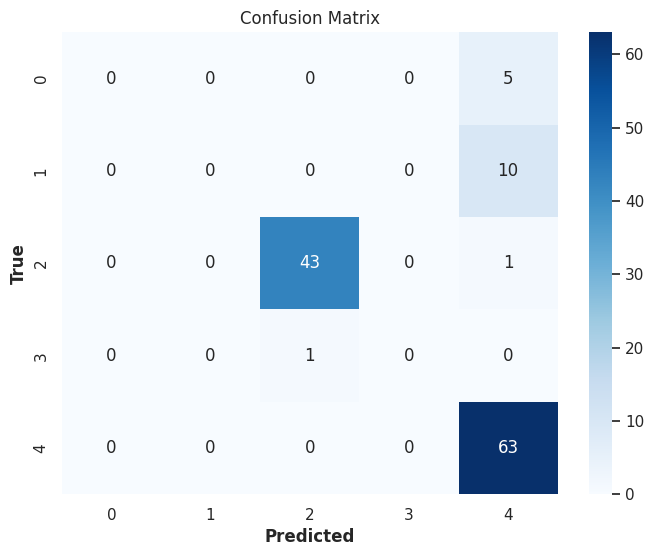

(999, 4)
Epoch 1/1000
32/32 [==============================] - 1s 9ms/step - loss: 1.4849 - accuracy: 0.4094 - val_loss: 1.4564 - val_accuracy: 0.4414
Epoch 2/1000
32/32 [==============================] - 0s 7ms/step - loss: 1.2127 - accuracy: 0.5225 - val_loss: 1.3541 - val_accuracy: 0.4414
Epoch 3/1000
32/32 [==============================] - 0s 6ms/step - loss: 1.0790 - accuracy: 0.5225 - val_loss: 1.3395 - val_accuracy: 0.4414
Epoch 4/1000
32/32 [==============================] - 0s 6ms/step - loss: 1.0452 - accuracy: 0.5225 - val_loss: 1.2840 - val_accuracy: 0.4414
Epoch 5/1000
32/32 [==============================] - 0s 5ms/step - loss: 1.0152 - accuracy: 0.5646 - val_loss: 1.2394 - val_accuracy: 0.4414
Epoch 6/1000
32/32 [==============================] - 0s 5ms/step - loss: 0.9823 - accuracy: 0.6316 - val_loss: 1.1978 - val_accuracy: 0.5766
Epoch 7/1000
32/32 [==============================] - 0s 5ms/step - loss: 0.9437 - accuracy: 0.6957 - val_loss: 1.1548 - val_accuracy: 0.61

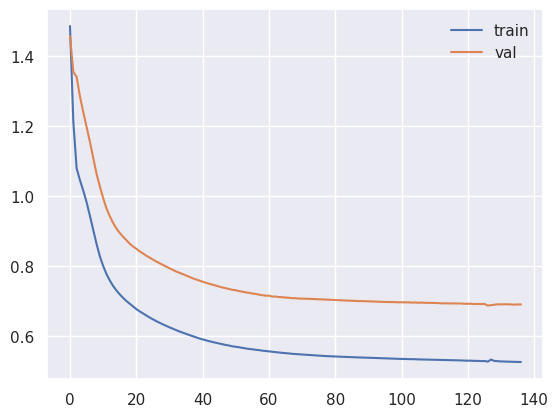

4/4 [==============================] - 0s 3ms/step
Accuracy on the test set: 0.8211382113821138


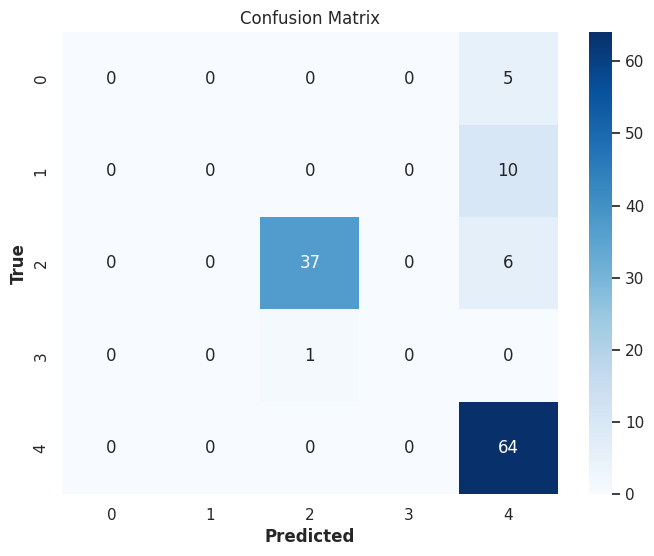

(999, 4)
Epoch 1/1000
32/32 [==============================] - 1s 8ms/step - loss: 1.3841 - accuracy: 0.5325 - val_loss: 1.2662 - val_accuracy: 0.4505
Epoch 2/1000
32/32 [==============================] - 0s 7ms/step - loss: 1.0941 - accuracy: 0.5215 - val_loss: 1.2188 - val_accuracy: 0.4505
Epoch 3/1000
32/32 [==============================] - 0s 6ms/step - loss: 1.0450 - accuracy: 0.5465 - val_loss: 1.1841 - val_accuracy: 0.4505
Epoch 4/1000
32/32 [==============================] - 0s 6ms/step - loss: 1.0184 - accuracy: 0.5876 - val_loss: 1.1431 - val_accuracy: 0.5045
Epoch 5/1000
32/32 [==============================] - 0s 6ms/step - loss: 0.9906 - accuracy: 0.6416 - val_loss: 1.1108 - val_accuracy: 0.5676
Epoch 6/1000
32/32 [==============================] - 0s 6ms/step - loss: 0.9627 - accuracy: 0.6817 - val_loss: 1.0727 - val_accuracy: 0.6216
Epoch 7/1000
32/32 [==============================] - 0s 5ms/step - loss: 0.9323 - accuracy: 0.7037 - val_loss: 1.0399 - val_accuracy: 0.64

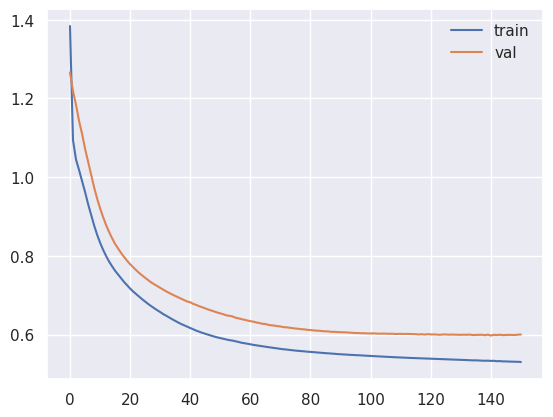

4/4 [==============================] - 0s 1ms/step
Accuracy on the test set: 0.8617886178861789


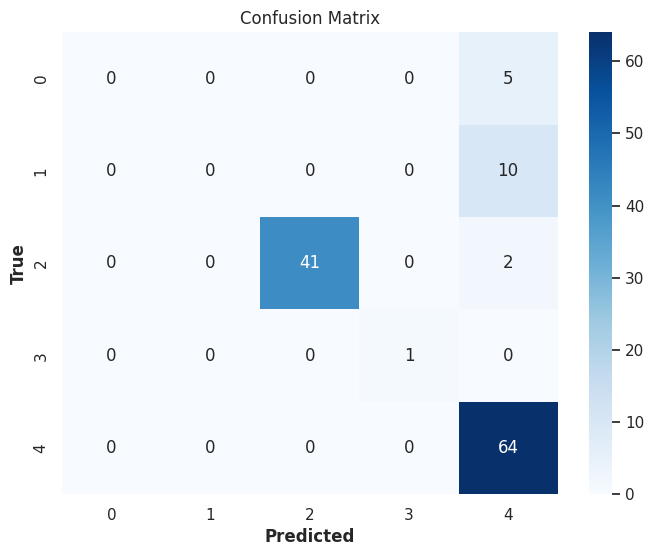

(999, 4)
Epoch 1/1000
32/32 [==============================] - 1s 8ms/step - loss: 1.4877 - accuracy: 0.3804 - val_loss: 1.4196 - val_accuracy: 0.4414
Epoch 2/1000
32/32 [==============================] - 0s 6ms/step - loss: 1.1918 - accuracy: 0.5235 - val_loss: 1.3454 - val_accuracy: 0.4324
Epoch 3/1000
32/32 [==============================] - 0s 6ms/step - loss: 1.0732 - accuracy: 0.5235 - val_loss: 1.3311 - val_accuracy: 0.4324
Epoch 4/1000
32/32 [==============================] - 0s 6ms/step - loss: 1.0380 - accuracy: 0.5385 - val_loss: 1.2667 - val_accuracy: 0.4324
Epoch 5/1000
32/32 [==============================] - 0s 6ms/step - loss: 1.0042 - accuracy: 0.6266 - val_loss: 1.2169 - val_accuracy: 0.4955
Epoch 6/1000
32/32 [==============================] - 0s 6ms/step - loss: 0.9688 - accuracy: 0.6717 - val_loss: 1.1682 - val_accuracy: 0.6036
Epoch 7/1000
32/32 [==============================] - 0s 6ms/step - loss: 0.9302 - accuracy: 0.7157 - val_loss: 1.1247 - val_accuracy: 0.62

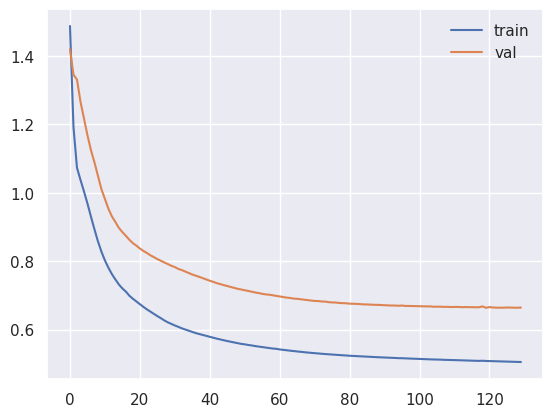

4/4 [==============================] - 0s 2ms/step
Accuracy on the test set: 0.8211382113821138


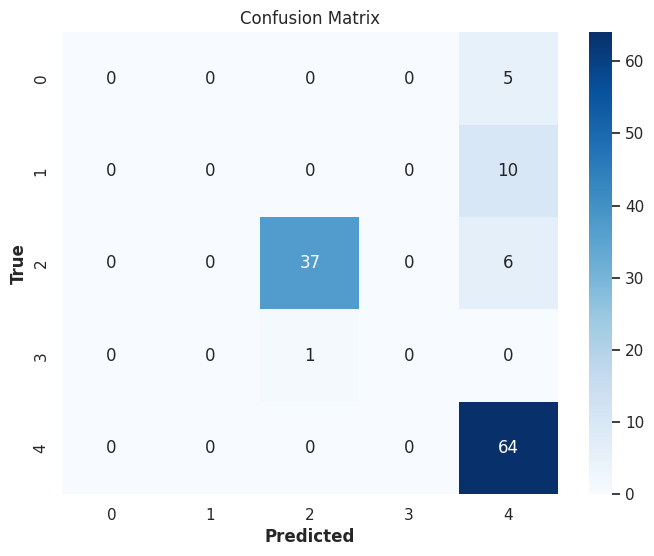

(999, 4)
Epoch 1/1000
32/32 [==============================] - 1s 8ms/step - loss: 1.3777 - accuracy: 0.5205 - val_loss: 1.3028 - val_accuracy: 0.4505
Epoch 2/1000
32/32 [==============================] - 0s 7ms/step - loss: 1.1101 - accuracy: 0.5215 - val_loss: 1.2879 - val_accuracy: 0.4505
Epoch 3/1000
32/32 [==============================] - 0s 6ms/step - loss: 1.0718 - accuracy: 0.5215 - val_loss: 1.2591 - val_accuracy: 0.4505
Epoch 4/1000
32/32 [==============================] - 0s 6ms/step - loss: 1.0553 - accuracy: 0.5215 - val_loss: 1.2251 - val_accuracy: 0.4505
Epoch 5/1000
32/32 [==============================] - 0s 6ms/step - loss: 1.0370 - accuracy: 0.5215 - val_loss: 1.1949 - val_accuracy: 0.4505
Epoch 6/1000
32/32 [==============================] - 0s 5ms/step - loss: 1.0160 - accuracy: 0.5846 - val_loss: 1.1626 - val_accuracy: 0.4505
Epoch 7/1000
32/32 [==============================] - 0s 6ms/step - loss: 0.9907 - accuracy: 0.6376 - val_loss: 1.1260 - val_accuracy: 0.56

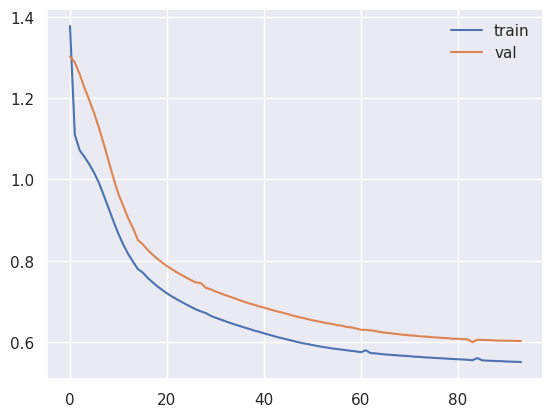

4/4 [==============================] - 0s 2ms/step
Accuracy on the test set: 0.8699186991869918


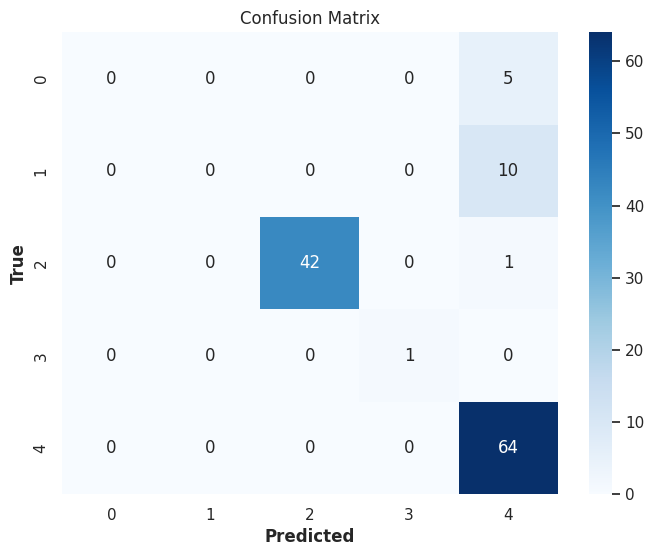

(999, 4)
Epoch 1/1000
32/32 [==============================] - 1s 9ms/step - loss: 1.4627 - accuracy: 0.4394 - val_loss: 1.3304 - val_accuracy: 0.4595
Epoch 2/1000
32/32 [==============================] - 0s 7ms/step - loss: 1.1549 - accuracy: 0.5205 - val_loss: 1.2120 - val_accuracy: 0.4595
Epoch 3/1000
32/32 [==============================] - 0s 6ms/step - loss: 1.0623 - accuracy: 0.5285 - val_loss: 1.2062 - val_accuracy: 0.4595
Epoch 4/1000
32/32 [==============================] - 0s 6ms/step - loss: 1.0319 - accuracy: 0.5996 - val_loss: 1.1768 - val_accuracy: 0.4865
Epoch 5/1000
32/32 [==============================] - 0s 6ms/step - loss: 1.0045 - accuracy: 0.6416 - val_loss: 1.1478 - val_accuracy: 0.5225
Epoch 6/1000
32/32 [==============================] - 0s 7ms/step - loss: 0.9758 - accuracy: 0.6697 - val_loss: 1.1122 - val_accuracy: 0.5856
Epoch 7/1000
32/32 [==============================] - 0s 6ms/step - loss: 0.9427 - accuracy: 0.6997 - val_loss: 1.0819 - val_accuracy: 0.60

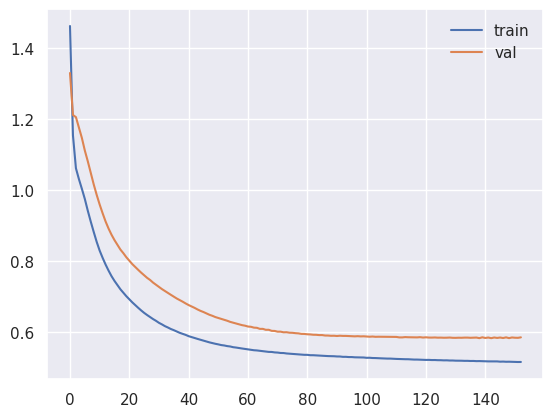

4/4 [==============================] - 0s 2ms/step
Accuracy on the test set: 0.8373983739837398


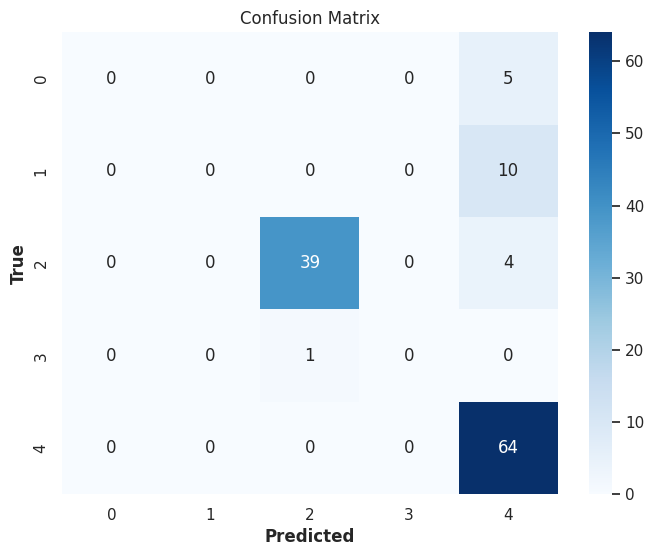

(999, 4)
Epoch 1/1000
32/32 [==============================] - 1s 8ms/step - loss: 1.4854 - accuracy: 0.5145 - val_loss: 1.3895 - val_accuracy: 0.4505
Epoch 2/1000
32/32 [==============================] - 0s 7ms/step - loss: 1.1831 - accuracy: 0.5225 - val_loss: 1.2597 - val_accuracy: 0.4505
Epoch 3/1000
32/32 [==============================] - 0s 7ms/step - loss: 1.0597 - accuracy: 0.5225 - val_loss: 1.2425 - val_accuracy: 0.4505
Epoch 4/1000
32/32 [==============================] - 0s 6ms/step - loss: 1.0328 - accuracy: 0.5526 - val_loss: 1.2060 - val_accuracy: 0.4685
Epoch 5/1000
32/32 [==============================] - 0s 6ms/step - loss: 1.0131 - accuracy: 0.5936 - val_loss: 1.1758 - val_accuracy: 0.5045
Epoch 6/1000
32/32 [==============================] - 0s 6ms/step - loss: 0.9896 - accuracy: 0.6376 - val_loss: 1.1486 - val_accuracy: 0.5405
Epoch 7/1000
32/32 [==============================] - 0s 6ms/step - loss: 0.9631 - accuracy: 0.6637 - val_loss: 1.1180 - val_accuracy: 0.59

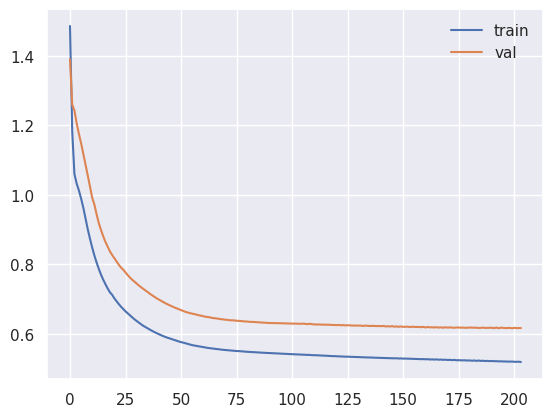

4/4 [==============================] - 0s 2ms/step
Accuracy on the test set: 0.8536585365853658


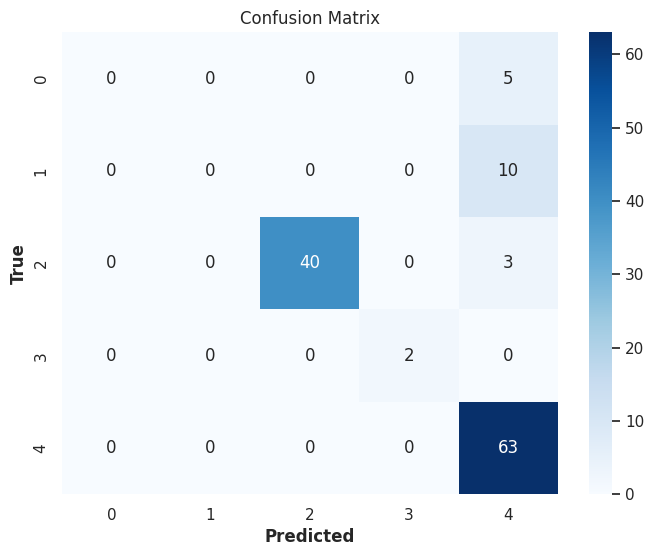

In [1545]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
maes=[]
y_integer = np.argmax(y, axis=1)
for train_index, test_index in kfold.split(X,y_integer):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test= y[train_index, :], y[test_index, :]
    val_split = int(len(train_index) * 0.9)  # Adjust the validation split percentage as needed
    X_train, x_val = X_train[:val_split], X_train[val_split:]
    y_train, y_val = y_train[:val_split, :], y_train[val_split:, :]

    print(X_train.shape)

    model=build_model(input_shape=(X_train.shape[1]),output_shape=y_train.shape[1])
    history=model.fit(X_train,y_train,epochs=1000,validation_data=(x_val,y_val),shuffle=False, callbacks=[early_stop])
    plt.plot(history.history['loss'],label='train')
    plt.plot(history.history['val_loss'],label='val')
    plt.legend()
    plt.show()

    #confusion matrix
    # Assuming you have a trained model named 'model'

    # Assuming you have a trained model named 'model' and your test set is X_test, y_test

    # Make predictions on the test set (X_test)
    predictions = model.predict(X_test)
    predicted_classes = np.argmax(predictions, axis=-1)

    test_classes = np.argmax(y_test, axis=-1)

    # If you used one-hot encoding for training labels, compare directly with y_test
    accuracy = (np.argmax(predictions, axis=-1) == np.argmax(y_test, axis=-1)).mean()
    print(f"Accuracy on the test set: {accuracy}")
    # Create a confusion matrix
    conf_matrix = confusion_matrix(test_classes, predicted_classes)

    # Display the confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    class_labels = [0, 1, 2, 3, 4]  # Replace with your actual class labels
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


   